<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Cell_Pose_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
import numpy as np
import pandas as pd
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0', 'images')
file_list = get_sub_files(folder)
file_list.sort()

Archive:  /content/images.zip
mapname:  conversion of  failed
replace /content/images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/RNF182_08-15-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_DG_40X_2XZoom_2.oir  
 extracting: /content/images/RNF182_08-17-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_CA3_40X_2XZoom_2.oir  
 extracting: /content/images/RNF182_08-12-22_S001_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Other/DifferentExposure_RNF182_08-15-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Other/BrighterSettings_Nel

In [100]:
im_num = 2
print(file_list[im_num])
my_reader = bioformats.get_image_reader('my_image', file_list[im_num])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir
800 800 3 17
(800, 800, 3, 17)


In [101]:
def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image


In [102]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
ch_names = ['target','mCherry','NeuN']




def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim

def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return masks, exp_masks


def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    results=pd.DataFrame(data=results,index=[0])

    return results


def image_pipeline(image,chan_dim,cell_chan,z_dim,t=0):
    image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
    diameter = 30
    exp_dist = 5
    masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
    cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
    results = calc_odd(cell_df,t)

    fov_dict = {'raw_image':image,
            'image_r':image_r,
            'image_znorm':image_znorm,
            'masks':masks,
            'exp_masks':exp_masks,
            'cell_df':cell_df,
            'results':results,
            }
    return fov_dict


In [145]:
from tqdm import tqdm


chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
exp_dist = 5


file_index = [i for i in range(len(file_list)) if 'MDGA' in file_list[i]]
sub_file_list = [file_list[i] for i in file_index]

multi_image_results = []
for f in tqdm( sub_file_list):
    image = read_image(f)
    fov_dict=image_pipeline(image,chan_dim,cell_chan,z_dim,t=1)
    fov_dict['image_name']=f
    multi_image_results.append(fov_dict)




  0%|          | 0/3 [00:00<?, ?it/s]

800 800 3 13


 33%|███▎      | 1/3 [04:49<09:38, 289.00s/it]

800 800 3 16


 67%|██████▋   | 2/3 [11:26<05:52, 352.86s/it]

800 800 3 17


100%|██████████| 3/3 [17:42<00:00, 354.33s/it]


         OR  num_RnG  num_nRnG  num_RG  num_nRG  targ_sig_nR  targ_sig_iR
0  1.382324       38       116      24       53      0.05738     0.064594
         OR  num_RnG  num_nRnG  num_RG  num_nRG  targ_sig_nR  targ_sig_iR
0  0.270325       41       266       2       48     0.085204      0.05933
         OR  num_RnG  num_nRnG  num_RG  num_nRG  targ_sig_nR  targ_sig_iR
0  1.356265       37       184       3       11     0.010518     0.011917


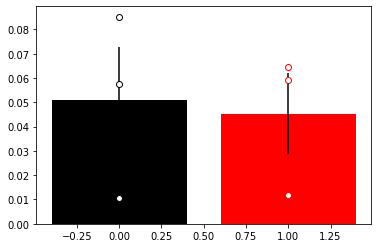

In [150]:

fig, ax = plt.subplots(1)

targ_nR_list = []
targ_iR_list = []
for im_i in range(len(multi_image_results)):
    print( multi_image_results[im_i]['results'])
    targ_nR_list.append(   multi_image_results[im_i]['results']['targ_sig_nR'] )
    targ_iR_list.append(   multi_image_results[im_i]['results']['targ_sig_iR'] )

# targ_iR_list = np.array(targ_iR_list)/np.array(targ_nR_list)
# targ_nR_list = np.array(targ_nR_list)/np.array(targ_nR_list)


ax.bar(0,np.mean(targ_nR_list),zorder = 0,color='k',yerr=scipy.stats.sem(targ_nR_list))
ax.bar(1,np.mean(targ_iR_list),zorder = 0,color='r',yerr=scipy.stats.sem(targ_iR_list))
ax.scatter(np.zeros_like(targ_nR_list),targ_nR_list,zorder = 1,edgecolor='k',facecolor='w')
ax.scatter(np.ones_like(targ_iR_list),targ_iR_list,zorder = 1,edgecolor='r',facecolor='w')

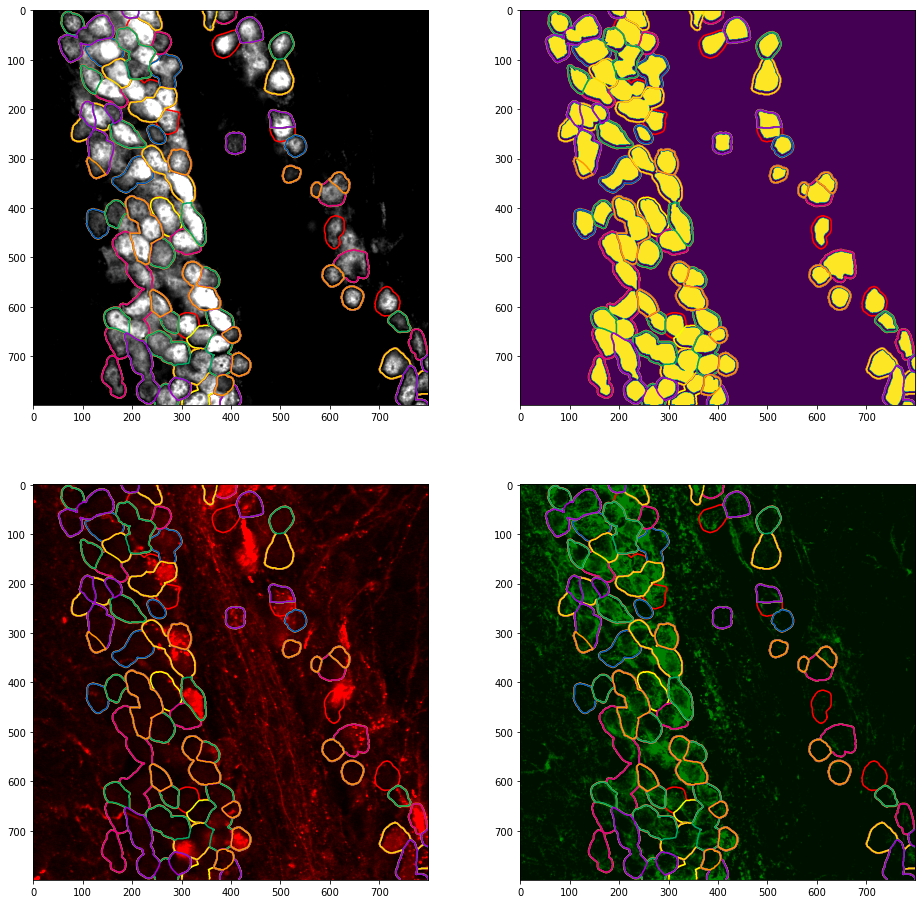

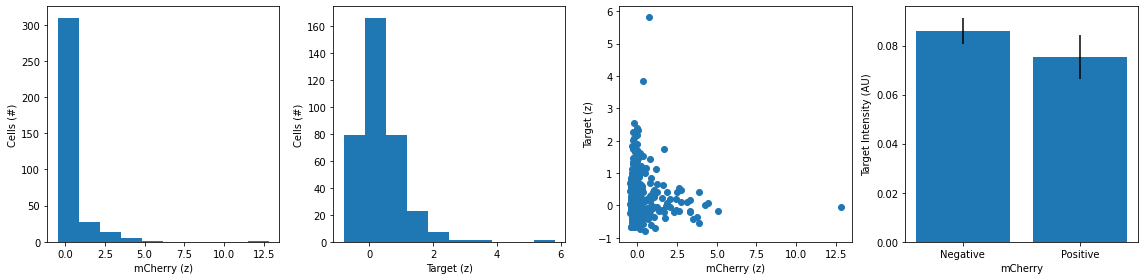

In [106]:
# from matplotlib.projections.polar import Axes
fov = multi_image_results[1]
zi = 9
sp_size =16
fig, axs = plt.subplots(2,2,figsize=(sp_size,sp_size))
axs =axs.flatten()
axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
axs[0].contour(fov['exp_masks'][zi,:,:],cmap='prism')


axs[1].imshow(fov['masks'][zi,:,:]>0)
axs[1].contour(fov['exp_masks'][zi,:,:],cmap='prism')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
axs[2].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
axs[2].contour(fov['exp_masks'][zi,:,:],cmap='prism')


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
axs[3].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmin=-1, vmax=3)
axs[3].contour(fov['exp_masks'][zi,:,:],cmap='prism')


sp_size =4
n=4
cell_df = fov['cell_df']
fig, ax = plt.subplots(1,n,figsize=(n*sp_size,sp_size))
ax=ax.flatten()
_=ax[0].hist(cell_df['mean_mCherry'])
ax[0].set_xlabel('mCherry (z)')
ax[0].set_ylabel('Cells (#)')

_=ax[1].hist(cell_df['mean_target'])
ax[1].set_xlabel('Target (z)')
ax[1].set_ylabel('Cells (#)')

ax[2].scatter(cell_df['mean_mCherry'],cell_df['mean_target'])
ax[2].set_xlabel('mCherry (z)')
ax[2].set_ylabel('Target (z)')


vals=[cell_df['raw_mean_target'][cell_df['mean_mCherry']<t],
      cell_df['raw_mean_target'][cell_df['mean_mCherry']>t]]
means = [np.mean(v) for v in vals]
errors = [np.std(v)/np.sqrt(v.size) for v in vals]


ax[3].bar([0,1],means,yerr=errors)
ax[3].set_xticks([0,1])
ax[3].set_xticklabels(['Negative','Positive'])
ax[3].set_xlabel('mCherry')
ax[3].set_ylabel('Target Intensity (AU)')
# ax[3].set_xticks()
# ax[3].title.set_text('mean_NeuN')

plt.tight_layout()
plt.show()

In [122]:
print(multi_image_results[0]['results'])

         OR  num_RnG  num_nRnG  num_RG  num_nRG
0  1.382324       38       116      24       53


In [119]:
import numpy as np
import h5py
from google import colab
sub_f = 'data'
zip_name = sub_f+'.zip'
try: os.makedirs(sub_f)
except: None
try: hf.close()
except: None
for f in multi_image_results:
    image_name_loc = f['image_name']
    h5_name = os.path.basename(image_name_loc).split('.')[0]
    hf = h5py.File( sub_f+'/'+h5_name+'.h5', 'w')
    for k,v in f.items():
        hf.create_dataset(k, data=v)
    hf.close()
!zip -r $zip_name $sub_f
colab.files.download(zip_name)


  adding: data/ (stored 0%)
  adding: data/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.h5 (deflated 87%)
  adding: data/MDGA2_08-25-22_DG_40X_2XZoom_1.h5 (deflated 89%)
  adding: data/MDGA2_08-24-22_DG_40X_2XZoom_1.h5 (deflated 85%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>